# Extracting Sentiment Networks from Shakespeare’s Plays

This paper makes use of the AFINN library (https://github.com/fnielsen/afinn). We contacted the authors to enquire if they published supplementary material, including source code, but as of yet we haven't received a reply. Therefore, we wrote our own code based on the descriptions in the paper.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

import pandas as pd
import nltk
import string
from collections import OrderedDict

# Using AFINN library - pip install afinn
from afinn import Afinn

# Load the NLTK punkt tokenizer - uncomment the next line if you don't have the punkt tokenizer 
# installed - it will open a dialog that will allow you to do so.
#nltk.download()


In [10]:
# Read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores



In [11]:
print(df.head)

<bound method NDFrame.head of            Play  Act  Scene             Speaker  \
0       a_and_c  0.0    0.0               PHILO   
1       a_and_c  0.0    0.0           CLEOPATRA   
2       a_and_c  0.0    0.0         MARK ANTONY   
3       a_and_c  0.0    0.0           CLEOPATRA   
4       a_and_c  0.0    0.0         MARK ANTONY   
5       a_and_c  0.0    0.0           Attendant   
6       a_and_c  0.0    0.0         MARK ANTONY   
7       a_and_c  0.0    0.0           CLEOPATRA   
8       a_and_c  0.0    0.0         MARK ANTONY   
9       a_and_c  0.0    0.0           CLEOPATRA   
10      a_and_c  0.0    0.0         MARK ANTONY   
11      a_and_c  0.0    0.0           CLEOPATRA   
12      a_and_c  0.0    0.0         MARK ANTONY   
13      a_and_c  0.0    0.0           CLEOPATRA   
14      a_and_c  0.0    0.0         MARK ANTONY   
15      a_and_c  0.0    0.0           DEMETRIUS   
16      a_and_c  0.0    0.0               PHILO   
17      a_and_c  0.0    0.0           DEMETRIUS   
1

## Differentiating comedies from tragedies

The paper first attempts to differentiate comedies from tragedies based on the summed valence for each play.

In [3]:
awv = {}

for play in df.Play.unique():
    dfp = df[df['Play']==play]

    # Sum the valences for each of the utterances
    sum_valence = dfp.afinn.sum()
    
    # Generate one big string for the full play
    alltext = ''
    for text in dfp['Utterance']:
        alltext += text + ' '
    
    
    # The following lines can be added if you wish to take into account the play's length
    #
    
    # Create a dictionary using a comprehension - this maps every character from
    # string.punctuation to None. Initialize a translation object from it.
    #translator = str.maketrans({key: None for key in string.punctuation})

    # Remove the punctuation using the translator
    #no_punctuation = alltext.translate(translator)
    
    # Split the play into tokens
    #tokens = nltk.word_tokenize(no_punctuation)

    # Calculate the number of words in the play
    #len_play = len(tokens)
    
    
    # Find the number of words in AFINN that are in the play
    words_in_afinn = afinn.find_all(alltext)


    # Calculate the average word valence
    # The paper seems to infer there are two methods to calculate it:
    # i) "Fig. 1. For each play the valence for each word was summed and then divided by the number
    # of words in both the word list (AFINN) and the respective play."
    # ii) "...  by summing the valence values for all words in the play and then dividing by the number 
    # of the play’s words in AFINN"
    #
    # We've chosen the later.
    awv[play] = (sum_valence / len(words_in_afinn)) 

    
# Define the list of tragedies and comedies in the order given in the paper
tragedies = ['titus','r_and_j', 'j_caesar', 'hamlet', 'othello', 'timon', 'lear', 'macbeth', 'a_and_c', 'coriolan']
comedies = ['all_well', 'as_you', 'com_err', 'lll', 'm_for_m', 'merchant', 'm_wives', 'dream', 'much_ado', 'pericles',
           'taming', 't_night', 'two_gent', 'win_tale']
all_labels = comedies + tragedies 

awv_sorted = OrderedDict()
for name in comedies:
    awv_sorted[name] = awv[name]
    
for name in tragedies:
    awv_sorted[name] = awv[name]

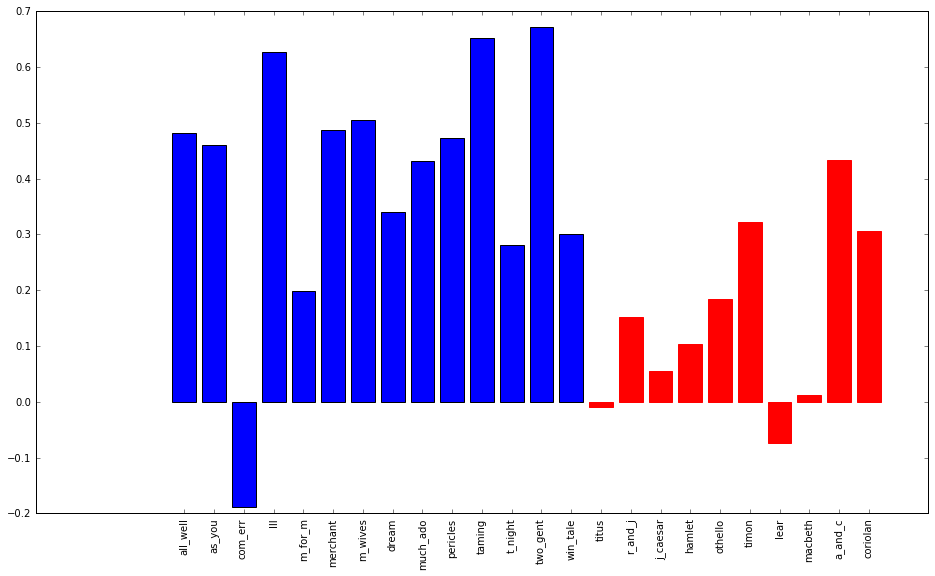

In [4]:
plt.rcParams["figure.figsize"] = (16,9)

bar=plt.bar(range(len(awv_sorted)), awv_sorted.values(), align='center', color='blue')

# Change the color of the tragedies to red
for i in range(len(comedies),len(comedies)+len(tragedies)):
    bar[i].set_color('red')

plt.xticks(range(len(all_labels)), all_labels)

ax = plt.axes()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

## Character-to-Character Analysis

The paper next attempts to determine the sentiment between characters. The character-to-character sentiment is determined by "summing the valence values over each instance of continuous speech and then assumed that sentiment was directed towards the character that spoke immediately before the current speaker." Our data structure is ordered by speaker and so we can simply iterate through it and calculate the valence.


In [5]:
from_character = {}
speaker = ''
previous_speaker = ''

# We'll look at character interactions in Hamlet
dfp = df[df.Play=='hamlet']

# Iterate through all Utterances
for i, r in dfp.iterrows():

    # Determine who is speaking
    speaker = r['Speaker']

    # Only calculate if someone spoke before
    if len(previous_speaker) > 0:
        # Get the list of speakers that this speaker has spoken to
        if speaker in from_character:
            to_character = from_character[speaker]
        else:
            to_character = {}
            from_character[speaker] = to_character

        # Get the running total of sentiment valence so far and add the new valence
        if previous_speaker in to_character:
            to_character[previous_speaker] += r['afinn']
        else:
            to_character[previous_speaker] = r['afinn']

    # The current speaker will become the previous speaker for the next utterance
    previous_speaker = speaker

In [6]:
# Print out Hamlet's Sentiment Valence Sum 
from IPython.display import display, HTML
df_print = pd.DataFrame(list(from_character['HAMLET'].items()), columns=['Speaker', 'Valence'])

df_print.sort_values('Valence',inplace=True, ascending=False)
display(df_print)

,Speaker,Valence
17,QUEEN GERTRUDE,37.0
15,GUILDENSTERN,27.0
3,HORATIO,21.0
18,LORD POLONIUS,20.0
12,First Player,16.0
10,ROSENCRANTZ,10.0
7,OPHELIA,9.0
11,MARCELLUS,8.0
0,Lord,7.0
8,Ghost,7.0


In [8]:
# Print out Hamlet's Sentiment Valence Sum 

df_print2 = pd.DataFrame(list(from_character['GUILDENSTERN'].items()), columns=['Speaker', 'Valence'])

df_print2.sort_values('Valence',inplace=True, ascending=False)
display(df_print2)

,Speaker,Valence
3,HAMLET,28.0
0,ROSENCRANTZ,9.0
2,QUEEN GERTRUDE,5.0
1,KING CLAUDIUS,-1.0


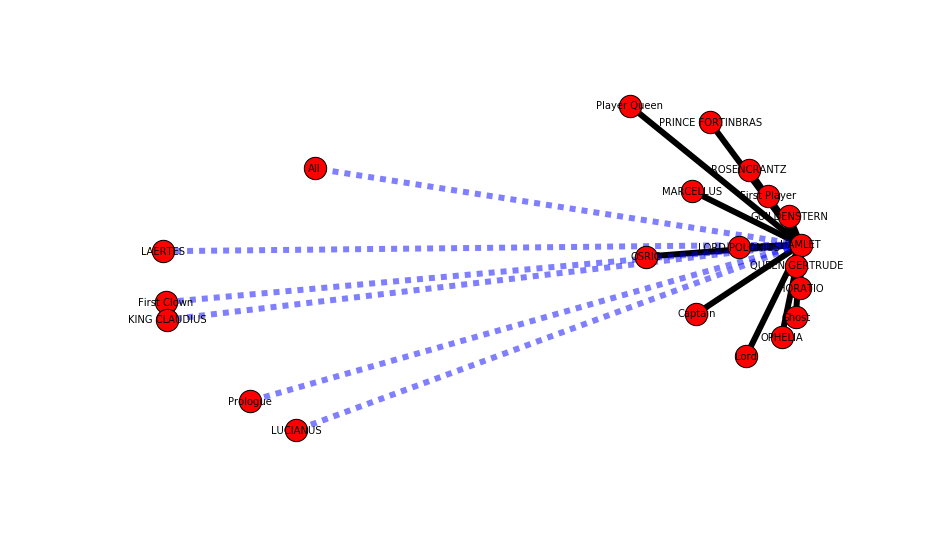

In [7]:
import networkx as nx

G=nx.Graph()

for i, r in df_print.iterrows():
    G.add_edge('HAMLET',r['Speaker'],weight=r['Valence'])


elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=500)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.axis('off')
plt.show() # display